In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL.Image import open as pil_open
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models import resnet34, ResNet34_Weights
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset

In [2]:
LABEL_MAP = {
    "United States": 1,
    "Japan": 2,
    "France": 3
}

In [3]:
class CFG:
    ROOT_DIR = pathlib.Path("/home/fummicc1/codes/classes/machine_intelligence/Machine-Intelligence-Team-8")
    DATA_DIR = ROOT_DIR / "compressed_dataset"
    
    BATCH_SIZE = 32
    NUM_WORKERS = 8
    
    EPOCHS = 10
    LR = 1e-3
    
    NUM_CLASSSES = len(LABEL_MAP) + 1
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    IMG_SIZE = (662, 1536)
    

In [4]:
train_df = pd.DataFrame()
countries = ["United States", "Japan", "France"]

In [5]:
for country in countries:
    folder = CFG.DATA_DIR / country
    df = pd.DataFrame()
    df["label"] = [LABEL_MAP[country] for i in range(len(list(folder.iterdir())))]
    df["img"] = list(folder.iterdir())
    train_df = pd.concat([train_df, df])

In [6]:
train_df

,label,img
0,1,/home/fummicc1/codes/classes/machine_intellige...
1,1,/home/fummicc1/codes/classes/machine_intellige...
2,1,/home/fummicc1/codes/classes/machine_intellige...
3,1,/home/fummicc1/codes/classes/machine_intellige...
4,1,/home/fummicc1/codes/classes/machine_intellige...
...,...,...
3568,3,/home/fummicc1/codes/classes/machine_intellige...
3569,3,/home/fummicc1/codes/classes/machine_intellige...
3570,3,/home/fummicc1/codes/classes/machine_intellige...
3571,3,/home/fummicc1/codes/classes/machine_intellige...


## Dataset

In [7]:
class GeoLocationDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform: A.Compose, train: bool) -> None:
        super().__init__()
        self.df = df
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index) -> torch.Tensor:
        data = self.df.iloc[index]
        if self.train:
            label = data["label"]
        img_path = data["img"]
        img = pil_open(img_path).convert("RGB")
        img = np.array(img)
        img = img[:, 100:500, :]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        if self.train:
            return img, label
        return img
        

In [8]:
def train_transform() -> A.Compose:    
    return A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(),
        A.Resize(height=CFG.IMG_SIZE[0], width=CFG.IMG_SIZE[0]),
        ToTensorV2(),        
    ])

In [9]:
def val_transform() -> A.Compose:
    return A.Compose([
        A.Resize(height=CFG.IMG_SIZE[0], width=CFG.IMG_SIZE[0]),
        ToTensorV2(),
    ])

## Model

In [10]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.backbone = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.fc = nn.Linear(
            1000,
            CFG.NUM_CLASSSES
        )
        
    def forward(self, x: torch.Tensor):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [11]:
train_df = train_df[train_df["label"].isin(LABEL_MAP.values())]

In [12]:
train_dataset = GeoLocationDataset(
    df=train_df,
    transform=train_transform(),
    train=True
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=True,
    pin_memory=True,
)

## Check

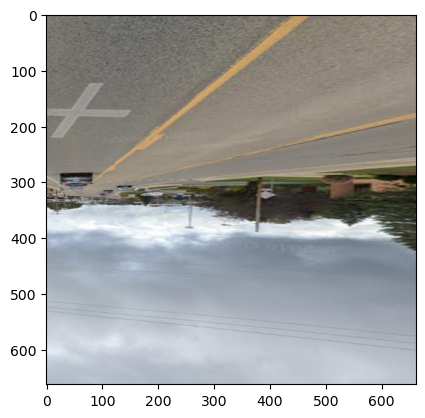

In [13]:
img = train_dataset[0][0]
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)

In [14]:
model = Model()
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optim = optim.AdamW(model.parameters(), lr=CFG.LR)

In [15]:
def train_one_epoch(model: Model):
    model = model.train().to(CFG.device)
    acc = 0
    losses = 0
    for imgs, labels in train_dataloader:
        optim.zero_grad()
        imgs = imgs.to(CFG.device).float()
        labels = labels.to(CFG.device)
        out = model(imgs)
        loss = criterion(out, labels)
        out = nn.Softmax(dim=1)(out)
        out = torch.argmax(out, dim=1)
        corrects = (out == labels).sum().item()
        acc += corrects
        loss.backward()
        optim.step()
        losses += loss.item()
    acc = acc / len(train_dataset)
    losses = losses / len(train_dataset)
    print(f"acc: {acc:.2f}")
    print(f"loss: {losses:.3f}")
        

In [16]:
for epoch in range(CFG.EPOCHS):
    print(f"--- start epoch: {epoch} ---")
    train_one_epoch(model)

--- start epoch: 0 ---
acc: 0.61
loss: 0.029
--- start epoch: 1 ---
acc: 0.62
loss: 0.028
--- start epoch: 2 ---
acc: 0.63
loss: 0.027
--- start epoch: 3 ---
acc: 0.64
loss: 0.027
--- start epoch: 4 ---
acc: 0.65
loss: 0.026
--- start epoch: 5 ---
acc: 0.65
loss: 0.026
--- start epoch: 6 ---
acc: 0.66
loss: 0.025
--- start epoch: 7 ---
acc: 0.67
loss: 0.025
--- start epoch: 8 ---
acc: 0.67
loss: 0.024
--- start epoch: 9 ---
acc: 0.68
loss: 0.024


## Predictions

In [17]:
img = pil_open("japan_001.jpg").convert("RGB")
img = np.array(img)
img = val_transform()(image=img)["image"]
img = torch.unsqueeze(img, dim=0)
img = img.to(CFG.device).float()

out = model(img)
pred = nn.Softmax(dim=1)(out)
print(pred)
index = torch.argmax(pred).item()
index

tensor([[1.7127e-08, 7.7737e-01, 9.2999e-02, 1.2963e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


1